In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import nelpy as nel
import nelpy.plotting as npl

%matplotlib inline

In [2]:
import jagular as jag

In [3]:
file_list = ['../sample_data/sample_data_1.rec',
             '../sample_data/sample_data_3.rec',
             '../sample_data/sample_data_4.rec',
             '../sample_data/sample_data_5.rec',
             '../sample_data/sample_data_2.rec'
            ]

jfm = jag.io.JagularFileMap(file_list)

AssertionError: first_timestamp > last_timestamp!

In [11]:
jag.io.JagularFileMap('../sample_data/sample_data_6.rec')

FileNotFoundError: [Errno 2] No such file or directory: '../sample_data/sample_data_6.rec'

In [8]:
jfm.timestamps

array([[ 125149761,  125149771],
       [4031182210, 4027970967],
       [4159699373, 4159109633],
       [4165344798, 4163313127],
       [4220446420, 4222215967]], dtype=int64)

In [7]:
npl.epochplot(nel.EpochArray(jfm.timestamps))

ValueError: start must be less than or equal to stop

In [6]:
jfm._check_bounds(1000000000, 100000000 )

ValueError: start time has to be less or equal to stop time!

In [209]:
Nfiles = 10
ts_starts = np.random.randint(0, high=90000000, size=Nfiles+1)
# ts_starts.sort()
new_order = sorted(range(len(ts_starts)), key=lambda k: ts_starts[k])
ll = ts_starts[new_order].tolist()
ll

[6419723,
 9785285,
 19614971,
 20535829,
 21405531,
 27585634,
 53854628,
 54017239,
 55093314,
 56757623,
 74642896]

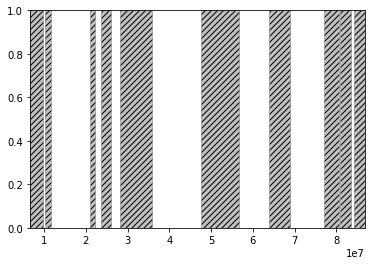

In [45]:
# make artificial timestamp boundaries
Nfiles = 10
ts_starts = np.random.randint(0, high=90000000, size=Nfiles+1)
ts_starts.sort()
ts_stops = np.zeros(ts_starts.shape)
for ii, ts in enumerate(ts_starts[:-1]):
    ts_stops[ii] = ts_starts[ii] + np.random.randint(ts_starts[ii+1] - ts_starts[ii])
ts_starts = ts_starts[:-1]
ts_stops = ts_stops[:-1]
ts = np.vstack((ts_starts, ts_stops)).T

npl.epochplot(nel.EpochArray(ts))

In [ ]:
def which_files(ts_start, ts_stop, filemap):
    

In [1]:
filemap = {}
filemap[10488726] = ('file1', 20488726)

In [317]:
import os
import xml.etree.ElementTree as ET
import struct

class FileInfo():
 
    def __init__(self, *, start_byte_size=None, timestamp_size=None, bytes_per_neural_channel=None, header_size=None):
        # set defaults:
        if start_byte_size is None:
            start_byte_size = 1
        if timestamp_size is None:
            timestamp_size = 4
        if bytes_per_neural_channel is None:
            bytes_per_neural_channel = 2
        if header_size is None:
            header_size = start_byte_size
            
        self.start_byte_size = start_byte_size
        self.timestamp_size = timestamp_size
        self.bytes_per_neural_channel = bytes_per_neural_channel
        # minimum size of any packet
        self.header_size = header_size

    def get_timestamp_bounds(self, filename):
        #TODO: JOSH LET'S FIX THIS!!!
        self.header_size = 1
        ii = 0
        # read .rec file embedded workspace and copy to a string
        with open(filename, 'rb') as infile:
            instr = infile.readline()
            while(instr != b'</Configuration>\n'):
                instr = infile.readline()
                ii += 1
                # infinite loop protection
                if ii > 1000:
                    print("Configuration info not found - check input file")
                    break
            config_section_size = infile.tell()
            infile.seek(0, os.SEEK_SET)
            xmlstring = infile.read(config_section_size)

            # create xml tree from copied embedded workspace string
            tree = ET.ElementTree(ET.fromstring(xmlstring))
            root = tree.getroot()
            hw_config = root.find("HardwareConfiguration")
        
            # calculate packet size
            if hw_config is None:
                print("No hardware configuration defined!")
            self.neural_data_size = int(hw_config.get("numChannels"))*self.bytes_per_neural_channel
            for elements in hw_config.getchildren():
                self.header_size += int(elements.get("numBytes"))
    
            # every packet needs a timestamp
            self.packet_size = self.header_size + self.timestamp_size + self.neural_data_size
            
            # find first and last timestamps of file
            infile.seek(config_section_size, os.SEEK_SET)
            packet = infile.read(self.packet_size)
            timestamp_start = self.header_size
            # <I format - assumes that the timestamp is an uint32
            first_timestamp = struct.unpack('<I', packet[timestamp_start:timestamp_start + self.timestamp_size])[0]
            infile.seek(-self.packet_size, os.SEEK_END)
            packet = infile.read(self.packet_size)
            last_timestamp = struct.unpack('<I', packet[timestamp_start:timestamp_start + self.timestamp_size])[0]
        
        return (first_timestamp, last_timestamp, filename)        


In [324]:
class JagularFileMap(object):
    
    def __init__(self, *files, **kwargs):
        self.file_list = None
        self._ts_starts = []
        self._ts_stops = []
        
        kwargs['start_byte_size'] = kwargs.get('start_byte_size', None)
        kwargs['timestamp_size'] = kwargs.get('timestamp_size', None)
        kwargs['bytes_per_neural_channel'] = kwargs.get('bytes_per_neural_channel', None)
        kwargs['header_size'] = kwargs.get('header_size', None)
        
        self._fi = FileInfo(**kwargs)
        
        file_tuple = self._get_file_tuple(files)
        if file_tuple:
            self.add_files(file_tuple)
        
    def _get_file_tuple(self, files):
        """'files' can be a list, tuple, or multiple arguments; returns a tuple."""
        try:
            if isinstance(files[0], (tuple, list)):
                files = files[0]
            return tuple(files)
        except IndexError:
            return ()
    
    def __repr__(self):
        address_str = " at " + str(hex(id(self)))
        return "<JagularFileMap>%s" % (address_str)
    
    def __pairwise(self, iterable):
        """returns a zip of all neighboring pairs.
        This is used as a helper function for is_sorted.

        Example
        -------
        >>> mylist = [2, 3, 6, 8, 7]
        >>> list(pairwise(mylist))
        [(2, 3), (3, 6), (6, 8), (8, 7)]
        """
        from itertools import tee
        
        a, b = tee(iterable)
        next(b, None)
        return zip(a, b)

    def __is_sorted(self, iterable, key=lambda a, b: a <= b):
        """Check to see if iterable is monotonic increasing (sorted)."""
        return all(key(a, b) for a, b in self.__pairwise(iterable))
    
    def add_files(self, *files):
        """Add files to internal list, and populate time boundaries."""
        # here we will read the files to extract first and last timestamps,
        # and we will update (not replace!) the internal list of files and
        # timestamps
        
        #TODO: check if value already exists, and warn user and take appropriate action
        file_tuple = self._get_file_tuple(files)
        
        for file in file_tuple:
            first_timestamp, last_timestamp, infile = self._fi.get_timestamp_bounds(file)
            self._ts_starts.append(first_timestamp)
            self._ts_stops.append(last_timestamp)
            if self.file_list:
                self.file_list.append(file)
            else:
                self.file_list = []
                self.file_list.append(file)
                
        print(self._ts_starts)
            
        if not self.issorted:
            self._sort()
            
    def _sort(self):
        """Sort filenames, and timestamps according to starting timestamps."""
        new_order = sorted(range(len(self._ts_starts)), key=lambda k: self._ts_starts[k])
        self._ts_starts = np.array(self._ts_starts)[new_order].tolist()
        self._ts_stops = np.array(self._ts_stops)[new_order].tolist()
        self.file_list = np.array(self.file_list)[new_order].tolist()
            
    @property
    def timestamps(self):
        """Timestamps array with size (n_files, 2), with each row as (start, stop)."""
        return np.vstack((self._ts_starts, self._ts_stops)).T
    
    @property
    def issorted(self):
        """Returns True if timestamps are monotonically increasing."""
        return self.__is_sorted(self._ts_starts)
        
    @property
    def isempty(self):
        """(bool) Empty JagularFileMap."""
        try:
            if len(self.file_list) > 0:
                return False
            else:
                return True
        except TypeError: # file_list is None
            return True
    
    @property
    def start(self):
        """First timestamp in JagularFileMap."""
        if not self.isempty:
            return self.timestamps[0,0]
        else:
            return np.inf
        
    @property
    def stop(self):
        """Last timestamp in JagularFileMap."""
        if not self.isempty:
            return self.timestamps[-1,1]
        else:
            return -np.inf
        
    @property
    def duration_w_gaps(self):
        """Total duration (in number of samples) mapped by file objects, including potential gaps."""
        if self.isempty:
            return 0
        else:
            return self.stop - self.start
        
    @property
    def duration_wo_gaps(self):
        """Total duration (in number of samples) mapped by file objects, excluding inter-file gaps.
        NOTE: intra-file gaps are not taken into account here, but should be relatively small.
        """
        raise NotImplementedError("not yet implemebted!")
            
    def _check_bounds(self, start, stop):
        """Check that [start, stop] is fully contained (inclusive) of [self.start, self.stop]"""
        if start < self.start:
            raise ValueError("requested start time is earlier than first avaialbe timestamp (={})!".format(self.start))
        if stop > self.stop:
            raise ValueError("requested stop time is later than last avaialbe timestamp (={})!".format(self.stop))
        return True

In [330]:
file_list = ['../sample_data/sample_data_1.rec',
             '../sample_data/sample_data_3.rec',
             '../sample_data/sample_data_4.rec',
             '../sample_data/sample_data_5.rec',
             '../sample_data/sample_data_2.rec'
            ]

In [331]:
jfm = JagularFileMap('../sample_data/sample_data_3.rec')

jfm.timestamps

[4220446420]


array([[4220446420, 4222215967]], dtype=int64)

In [332]:
jfm = JagularFileMap(file_list)

jfm._ts_starts

[125149761, 4220446420, 4031182210, 4159699373, 4165344798]


[125149761, 4031182210, 4159699373, 4165344798, 4220446420]

In [333]:
jfm.timestamps

array([[ 125149761,  125149771],
       [4031182210, 4027970967],
       [4159699373, 4159109633],
       [4165344798, 4163313127],
       [4220446420, 4222215967]], dtype=int64)

In [334]:
jfm.file_list

['../sample_data/sample_data_1.rec',
 '../sample_data/sample_data_4.rec',
 '../sample_data/sample_data_5.rec',
 '../sample_data/sample_data_2.rec',
 '../sample_data/sample_data_3.rec']

In [246]:
jfm = JagularFileMap('file1', 'file2')
jfm = JagularFileMap(L)
jfm = JagularFileMap()

jfm.add_files(('file1', 'file2', 'file3'))

jfm._check_bounds(5,6)

call Josh's get_timestamp_bounds on 'file1'
...updating internal table with filenames and timestamps


FileNotFoundError: [Errno 2] No such file or directory: 'file1'

In [40]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import nelpy as nel
import nelpy.plotting as npl

%matplotlib inline

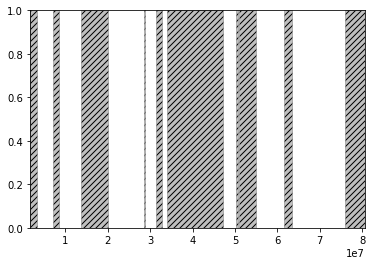